In [30]:
from src.data_preprocessor import DataProcessor
from data_configs.configs import *
from models.neural_networks import *
from src.cross_validation import CrossValidation
import numpy as np

config = breast_cancer_config
data_processor = DataProcessor(config=config)
cross_validator = CrossValidation(config=config)

In [31]:
raw_data = data_processor.load_data()
data_1 = data_processor.impute_missing_values(raw_data)
data_2 = data_1.drop(columns=['Sample code number'])
data_3 = data_processor.encode_ordinal_features(data_2)
data_4 = data_processor.standardize_data(data_3,data_3,features=['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses'])

In [32]:
data_4

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,0.206788,-0.699494,-0.742767,-0.632794,-0.549168,-0.706485,-0.179534,-0.611387,-0.343666,2
1,0.206788,0.283642,0.266684,0.768071,1.708882,1.792229,-0.179534,-0.283909,-0.343666,2
2,-0.503505,-0.699494,-0.742767,-0.632794,-0.549168,-0.428851,-0.179534,-0.611387,-0.343666,2
3,0.561934,1.594490,1.612618,-0.632794,-0.097558,0.126419,-0.179534,1.353485,-0.343666,2
4,-0.148359,-0.699494,-0.742767,0.067638,-0.549168,-0.706485,-0.179534,-0.611387,-0.343666,2
...,...,...,...,...,...,...,...,...,...,...
694,-0.503505,-0.699494,-0.742767,-0.632794,-0.097558,-0.428851,-0.999756,-0.611387,-0.343666,2
695,-0.858651,-0.699494,-0.742767,-0.632794,-0.549168,-0.706485,-0.999756,-0.611387,-0.343666,2
696,0.206788,2.249915,2.285586,0.067638,1.708882,-0.151216,1.871021,2.335921,0.239398,4
697,-0.148359,1.594490,0.939651,0.417854,-0.097558,0.126419,2.691243,1.026006,-0.343666,4


In [33]:
data_train, data_val = cross_validator.random_partition(data_4, random_state=42)

In [34]:
data_val = data_processor.encode_nominal_features(data_val)

In [35]:
data_val

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class_2,Class_4
158,-1.213798,-0.699494,-0.406284,-0.632794,-0.097558,0.000000,-0.999756,-0.611387,-0.343666,1,0
499,-0.148359,-0.699494,-0.742767,-0.632794,-0.549168,-0.706485,-0.589645,-0.611387,-0.343666,1,0
396,-0.503505,-0.699494,-0.742767,-0.632794,-0.549168,-0.706485,-0.179534,-0.611387,-0.343666,1,0
155,0.206788,0.611354,0.603167,1.118287,-0.097558,1.792229,-0.179534,-0.611387,-0.343666,0,1
321,-0.503505,-0.699494,-0.742767,-0.632794,-0.549168,0.000000,-0.179534,-0.611387,-0.343666,1,0
...,...,...,...,...,...,...,...,...,...,...,...
24,-1.213798,-0.699494,-0.742767,-0.632794,-0.549168,-0.706485,-0.179534,-0.611387,-0.343666,1,0
218,0.561934,2.249915,1.276135,1.468503,1.257272,0.126419,1.871021,2.335921,0.239398,0,1
431,0.206788,-0.699494,-0.742767,0.067638,0.354052,-0.706485,-0.179534,-0.283909,-0.343666,1,0
281,-0.858651,-0.699494,-0.742767,-0.282578,-0.549168,-0.706485,-0.179534,-0.611387,-0.343666,1,0


In [36]:
data_test = data_val.to_numpy()
X_val = data_test[:,:-2]
y_val = data_test[:,-2:]

In [37]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours

# Define the function to optimize
def evaluate_model(lr, epochs):
    scores = []
    
    for i, (train_set, _) in enumerate(cross_validator.cross_validation(data_train, n_splits=2, n_repeats=5, random_state=42, stratify=True)):
        
        # Ensure epochs is treated as an integer
        epochs = int(round(epochs))
        
        train_set = data_processor.encode_nominal_features(train_set)

        train_data = train_set.to_numpy()
        X_train = train_data[:,:-2]
        y_train = train_data[:,-2:]

        linear = LinearNetwork(config)

        _, val_losses = linear.logistic_regression(X_train, y_train, X_val, y_val, epochs=int(epochs), lr=lr)

        score = val_losses[-1]
        scores.append(score)

    avg_score = np.mean(scores)
    # print(f"Tested params: epochs: {epochs}, lr: {lr}, Score: {avg_score}")
    # Since Bayesian Optimization maximizes the function, and we want to minimize the validation loss, return the negative loss
    return -avg_score

# Hyperparameters ranges
pbounds = {
    'lr': (1e-6, 1e-2),  # Log scale
    'epochs': (1000, 20000)
}

# Bayesian Optimization
optimizer = BayesianOptimization(f=evaluate_model, pbounds=pbounds, random_state=42, verbose=2)

# Number of iterations
optimizer.maximize(init_points=10, n_iter=18)

# Best parameters found
print(Colours.yellow(f"Best parameters: {optimizer.max['params']}, Best score: {-optimizer.max['target']}"))


|   iter    |  target   |  epochs   |    lr     |
-------------------------------------------------
| 1         | -0.1111   | 8.116e+03 | 0.009507  |
| 2         | -0.1111   | 1.491e+04 | 0.005987  |
| 3         | -0.1106   | 3.964e+03 | 0.001561  |
| 4         | -0.1111   | 2.104e+03 | 0.008662  |
| 5         | -0.1111   | 1.242e+04 | 0.007081  |
| 6         | -0.1111   | 1.391e+03 | 0.009699  |
| 7         | -0.1111   | 1.682e+04 | 0.002124  |
| 8         | -0.1109   | 4.455e+03 | 0.001835  |
| 9         | -0.1111   | 6.781e+03 | 0.005248  |
| 10        | -0.1111   | 9.207e+03 | 0.002913  |
| 11        | -0.1111   | 3.717e+03 | 0.003746  |
| 12        | -0.1108   | 3.963e+03 | 0.001722  |
| 13        | -0.1111   | 3.968e+03 | 0.002694  |
| 14        | -0.1111   | 3.965e+03 | 0.004329  |
| 15        | -0.1111   | 1.368e+04 | 0.006422  |
| 16        | -0.1091   | 1.617e+03 | 0.002153  |
| 17        | -0.1111   | 1.619e+03 | 0.008089  |
| 18        | -0.1106   | 1.354e+03 | 0.004384  |


In [24]:
import random

iterations = 20

param_space = {
    'lr': [0.01,0.001,0.0001,0.00001,0.000001],
    'epochs': np.linspace(1000, 20000, num=20).astype(int).tolist()
}

best_score = float('inf')
best_params = {}

for _ in range(iterations):

    # Randomly select parameters
    params = {key: random.choice(value) for key, value in param_space.items()}
    scores = []

    for i, (train_set, _) in enumerate(cross_validator.cross_validation(data_train, n_splits=2, n_repeats=5, random_state=42, stratify=True)):
    
        train_set = data_processor.encode_nominal_features(train_set)

        train_data = train_set.to_numpy()
        X_train = train_data[:,:-2]
        y_train = train_data[:,-2:]

        linear = LinearNetwork(config)

        _, val_losses = linear.logistic_regression(X_train,y_train,X_val,y_val,epochs=params['epochs'],lr=params['lr'])

        score = val_losses[-1]
        scores.append(score)

    avg_score = np.mean(scores)

    print(f"Tested params: {params}, Score: {avg_score}")
    
    if avg_score < best_score:
        best_score = avg_score
        best_params = params
        

print(f"Best parameters: {best_params}, Best score: {best_score}")


Tested params: {'lr': 1e-05, 'epochs': 19000}, Score: 0.08519931826264589
Tested params: {'lr': 1e-05, 'epochs': 19000}, Score: 0.08520997359498218
Tested params: {'lr': 0.0001, 'epochs': 6000}, Score: 0.09711034705906542
Tested params: {'lr': 0.01, 'epochs': 20000}, Score: 0.1111178658131881
Tested params: {'lr': 0.001, 'epochs': 16000}, Score: 0.11111242697975414
Tested params: {'lr': 1e-05, 'epochs': 11000}, Score: 0.08095127324134256
Tested params: {'lr': 1e-05, 'epochs': 4000}, Score: 0.08402048568416853
Tested params: {'lr': 1e-05, 'epochs': 12000}, Score: 0.08142106492893333
Tested params: {'lr': 0.001, 'epochs': 20000}, Score: 0.11111694643028729
Tested params: {'lr': 0.001, 'epochs': 10000}, Score: 0.11103639083787324
Tested params: {'lr': 0.001, 'epochs': 10000}, Score: 0.11103650966541874
Tested params: {'lr': 0.0001, 'epochs': 15000}, Score: 0.10443761930118914
Tested params: {'lr': 0.01, 'epochs': 11000}, Score: 0.11111786581318808
Tested params: {'lr': 1e-06, 'epochs': 10

In [ ]:
import random

iterations = 20

param_space = {
    'lr': [0.0001,0.00001,0.000001,0.0000001],
    'epochs': np.linspace(1000, 20000, num=20).astype(int).tolist(),
    'n_hidden': np.linspace(X_val.shape[1],10*X_val.shape[1],num=20).astype(int).tolist()
}

best_score = float('inf')
best_params = {}

for _ in range(iterations):

    # Randomly select parameters
    params = {key: random.choice(value) for key, value in param_space.items()}
    scores = []

    for i, (train_set, _) in enumerate(cross_validator.cross_validation(data_train, n_splits=2, n_repeats=5, random_state=42, stratify=True)):
    
        train_set = data_processor.encode_nominal_features(train_set)

        train_data = train_set.to_numpy()
        X_train = train_data[:,:-2]
        y_train = train_data[:,-2:]

        ffn = FeedForwardNetwork(config,n_input=X_train.shape[1],n_hidden_1=params['n_hidden'],n_hidden_2=params['n_hidden'],n_output=y_train.shape[1])

        _, val_losses, _ = ffn.train(X_train,y_train,X_val,y_val,epochs=params['epochs'],lr=params['lr'])

        score = val_losses[-1]
        scores.append(score)

    avg_score = np.mean(scores)

    print(f"Tested params: {params}, Score: {avg_score}")
    
    if avg_score < best_score:
        best_score = avg_score
        best_params = params
        

print(f"Best parameters: {best_params}, Best score: {best_score}")


In [ ]:
data = data_train.to_numpy()
X_train = data[:,:-2]
y_train = data[:,-2:]

In [ ]:
data_test = data_val.to_numpy()
X_val = data_test[:,:-2]
y_val = data_test[:,-2:]

In [ ]:
X_train.shape

(559, 9)

In [ ]:
autoE = AutoEncoder(config,n_input=X_train.shape[1],n_encoder=5)

autoE.train(X_train, max_epochs=20000, lr=0.0001)

Epoch 0/20000, Loss: 1.0209138362070487
Epoch 1/20000, Loss: 1.0207975208292657
Epoch 2/20000, Loss: 1.0206823964067901
Epoch 3/20000, Loss: 1.0205645524975921
Epoch 4/20000, Loss: 1.0204405300553827
Epoch 5/20000, Loss: 1.0203071411066567
Epoch 6/20000, Loss: 1.0201613245417056
Epoch 7/20000, Loss: 1.0200000278815837
Epoch 8/20000, Loss: 1.0198201073773572
Epoch 9/20000, Loss: 1.0196182406565868
Epoch 10/20000, Loss: 1.0193908475249662
Epoch 11/20000, Loss: 1.0191340155853459
Epoch 12/20000, Loss: 1.0188434281478662
Epoch 13/20000, Loss: 1.0185142925468453
Epoch 14/20000, Loss: 1.0181412675094377
Epoch 15/20000, Loss: 1.017718388683312
Epoch 16/20000, Loss: 1.0172389918627702
Epoch 17/20000, Loss: 1.0166956338858404
Epoch 18/20000, Loss: 1.0160800116351962
Epoch 19/20000, Loss: 1.01538288008526
Epoch 20/20000, Loss: 1.0145939709139948
Epoch 21/20000, Loss: 1.0137019138523262
Epoch 22/20000, Loss: 1.0126941636806581
Epoch 23/20000, Loss: 1.011556936593518
Epoch 24/20000, Loss: 1.010275

Epoch 663/20000, Loss: 0.3562077523319124
Epoch 664/20000, Loss: 0.3561749940035145
Epoch 665/20000, Loss: 0.3561420532828724
Epoch 666/20000, Loss: 0.35610892622859724
Epoch 667/20000, Loss: 0.3560756088479539
Epoch 668/20000, Loss: 0.35604209709620627
Epoch 669/20000, Loss: 0.3560083868759619
Epoch 670/20000, Loss: 0.35597447403651444
Epoch 671/20000, Loss: 0.35594035437318644
Epoch 672/20000, Loss: 0.3559060236266708
Epoch 673/20000, Loss: 0.35587147748237224
Epoch 674/20000, Loss: 0.35583671156975
Epoch 675/20000, Loss: 0.3558017214616599
Epoch 676/20000, Loss: 0.35576650267369886
Epoch 677/20000, Loss: 0.3557310506635504
Epoch 678/20000, Loss: 0.35569536083033204
Epoch 679/20000, Loss: 0.3556594285139463
Epoch 680/20000, Loss: 0.35562324899443354
Epoch 681/20000, Loss: 0.35558681749132975
Epoch 682/20000, Loss: 0.35555012916302764
Epoch 683/20000, Loss: 0.3555131791061431
Epoch 684/20000, Loss: 0.35547596235488743
Epoch 685/20000, Loss: 0.3554384738804446
Epoch 686/20000, Loss: 0.

In [ ]:
combined = CombinedModel(autoE,n_hidden_2=50,n_output=y_val.shape[1])

loss, val_metrics, final_loss = combined.train(X_train,y_train,X_val,y_val,epochs=10000,lr=0.00001)

Epoch 0/10000, Train MSE: 0.6929079003077174, Val MSE: 0.6928462615296509
Epoch 100/10000, Train MSE: 0.6738713230403526, Val MSE: 0.669571119861667
Epoch 200/10000, Train MSE: 0.6629221895231998, Val MSE: 0.6554208000918464
Epoch 300/10000, Train MSE: 0.6565569408091907, Val MSE: 0.6466319782324007
Epoch 400/10000, Train MSE: 0.6527991340653541, Val MSE: 0.6410347203821177
Epoch 500/10000, Train MSE: 0.6505304758659266, Val MSE: 0.6373676517837696
Epoch 600/10000, Train MSE: 0.6491117910855136, Val MSE: 0.6348858209977722
Epoch 700/10000, Train MSE: 0.6481721716444491, Val MSE: 0.6331399639336863
Epoch 800/10000, Train MSE: 0.6474916448905917, Val MSE: 0.631851979612897
Epoch 900/10000, Train MSE: 0.6469352537422413, Val MSE: 0.6308438474803308
Epoch 1000/10000, Train MSE: 0.6464154369215052, Val MSE: 0.6299963191512745
Epoch 1100/10000, Train MSE: 0.6458700621568224, Val MSE: 0.6292243245057725
Epoch 1200/10000, Train MSE: 0.6452491277567214, Val MSE: 0.6284618152638073
Epoch 1300/10

In [ ]:
np.min(loss)

0.09159005648045748

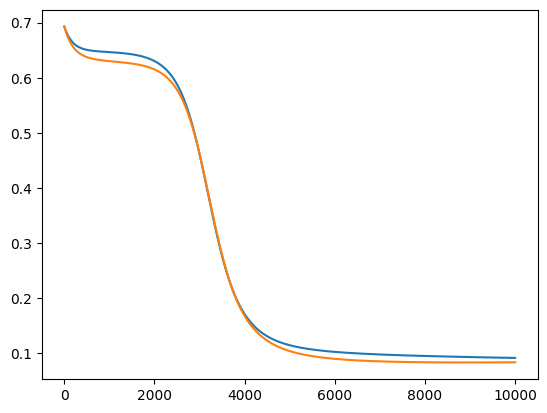

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.plot(val_metrics)

In [ ]:
ffn = FeedForwardNetwork(config,n_input=X_train.shape[1],n_hidden_1=24,n_hidden_2=24,n_output=y_train.shape[1])

loss, val_metrics, final_mse = ffn.train(X_train,y_train,X_val,y_val,5000,0.00001)

Epoch 0/5000, Train Loss: 0.6929593085057791, Val Loss: 0.6929070138097554
Epoch 100/5000, Train Loss: 0.6738262192727124, Val Loss: 0.6695317853644512
Epoch 200/5000, Train Loss: 0.6628154421320277, Val Loss: 0.655312576307758
Epoch 300/5000, Train Loss: 0.6564136212997074, Val Loss: 0.6464777429753712
Epoch 400/5000, Train Loss: 0.6526327273991073, Val Loss: 0.6408469234605132
Epoch 500/5000, Train Loss: 0.650343090672753, Val Loss: 0.6371481105525449
Epoch 600/5000, Train Loss: 0.64889403744151, Val Loss: 0.6346253144817824
Epoch 700/5000, Train Loss: 0.6479010392984349, Val Loss: 0.6328160782898976
Epoch 800/5000, Train Loss: 0.6471247120358874, Val Loss: 0.6314236448173206
Epoch 900/5000, Train Loss: 0.6463985968020712, Val Loss: 0.6302401322977309
Epoch 1000/5000, Train Loss: 0.6455801155378511, Val Loss: 0.6290947785780916
Epoch 1100/5000, Train Loss: 0.6445064132636379, Val Loss: 0.6278090479593729
Epoch 1200/5000, Train Loss: 0.6429350387644456, Val Loss: 0.6261393885294786
Ep

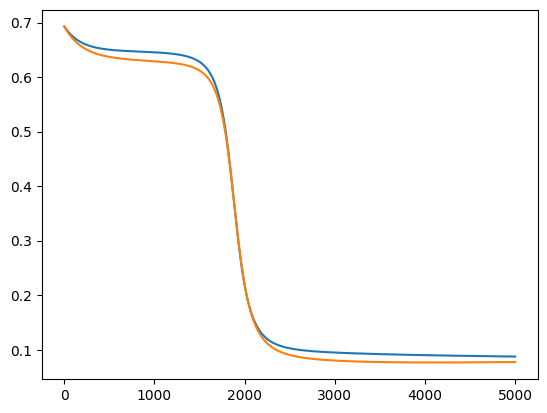

In [ ]:
plt.plot(loss)
plt.plot(val_metrics)

In [ ]:
linear = LinearNetwork(config)

losses, val_losses = linear.logistic_regression(X_train,y_train,X_val,y_val,epochs=1000,lr=0.001)

Epoch 0/1000, Training Loss: 0.6968024601906524, Validation Loss: 0.1496375852555422
Epoch 100/1000, Training Loss: 0.08601103610046926, Validation Loss: 0.08328741831591732
Epoch 200/1000, Training Loss: 0.08480587609501032, Validation Loss: 0.08927834151778374
Epoch 300/1000, Training Loss: 0.08456515028791894, Validation Loss: 0.09154433203820321
Epoch 400/1000, Training Loss: 0.08446172695277895, Validation Loss: 0.09260277760080146
Epoch 500/1000, Training Loss: 0.08440113744659827, Validation Loss: 0.09324917592327768
Epoch 600/1000, Training Loss: 0.08436234095383353, Validation Loss: 0.09372312990433358
Epoch 700/1000, Training Loss: 0.08433689304479451, Validation Loss: 0.09410082893188505
Epoch 800/1000, Training Loss: 0.08432009271740287, Validation Loss: 0.09441067426037085
Epoch 900/1000, Training Loss: 0.08430898763817535, Validation Loss: 0.0946667291136188


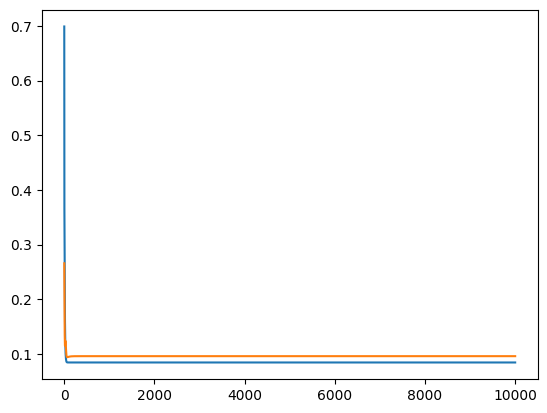

In [ ]:
plt.plot(losses)
plt.plot(val_losses)

## Tuning ##